In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import random
import time
%matplotlib inline
import matplotlib.animation as animation
import csv
matplotlib.style.use('seaborn')

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn import manifold
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster import hierarchy
from sklearn.cluster import DBSCAN
from sklearn.metrics.pairwise import pairwise_distances
# from wordcloud import WordCloud

from mpl_toolkits.mplot3d import Axes3D

In [2]:
blog_data=pd.read_csv("blogtext.csv")

In [3]:
blog_data.drop_duplicates(subset="text",inplace=True)
blog_data.date = pd.to_datetime(blog_data.date,errors="coerce",infer_datetime_format=True)
print(blog_data.shape)
blog_data.head()

(611652, 7)


,id,gender,age,topic,sign,date,text
0,2059027,male,15,Student,Leo,2004-05-14,"Info has been found (+/- 100 pages,..."
1,2059027,male,15,Student,Leo,2004-05-13,These are the team members: Drewe...
2,2059027,male,15,Student,Leo,2004-05-12,In het kader van kernfusie op aarde...
3,2059027,male,15,Student,Leo,2004-05-12,testing!!! testing!!!
4,3581210,male,33,InvestmentBanking,Aquarius,2004-06-11,Thanks to Yahoo!'s Toolbar I can ...


# Exploración de Variables

In [4]:
topic_user=pd.crosstab(index=blog_data.id, columns=blog_data.topic)
print(topic_user.shape)
sum((topic_user>0).sum(axis=1)>1)# Los autores se mantienen en el mismo tópico; por tanto es una variable del autor

(18981, 40)


0

In [5]:
author_data=blog_data.loc[:,["id","gender","age","topic","sign"]].drop_duplicates(subset="id")#,inplace=True)
author_data.index=author_data.id
author_data=author_data.loc[:,["gender","age","topic","sign"]]

In [6]:
author_data.head()

,gender,age,topic,sign
id,,,,
2059027,male,15,Student,Leo
3581210,male,33,InvestmentBanking,Aquarius
3539003,female,14,indUnk,Aries
4172416,female,25,indUnk,Capricorn
3668238,female,17,Student,Gemini


col_0   count
gender       
female   9509
male     9472


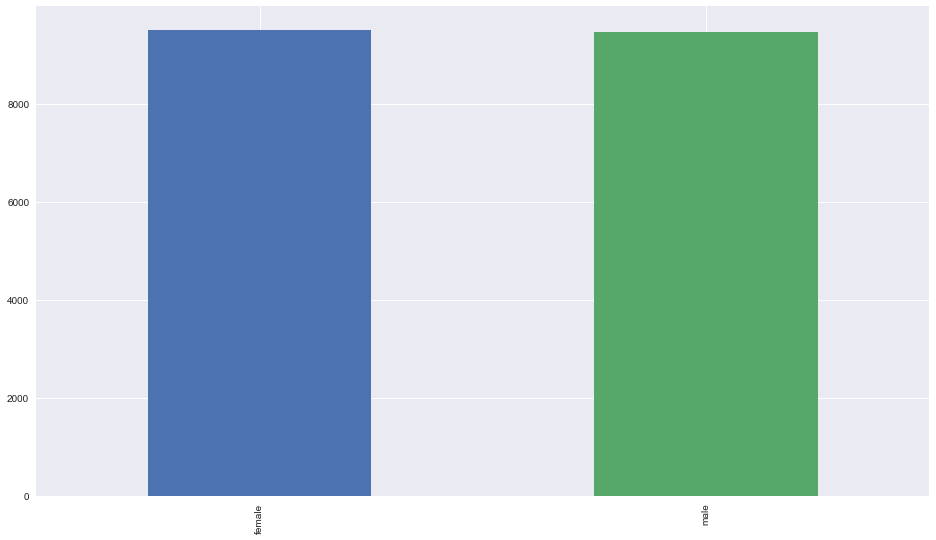

In [7]:
print(pd.crosstab(author_data.gender.fillna('missing'), columns="count",dropna=False))#.plot(kind="bar")
plt.figure(figsize=(16,9))
author_data['gender'].value_counts().plot(kind="bar")

C:\Users\Alexis\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


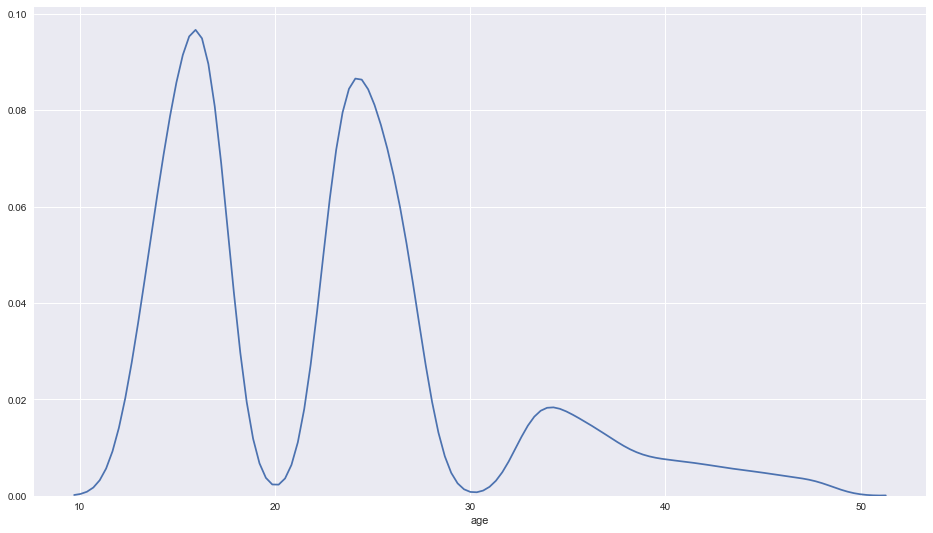

In [8]:
plt.figure(figsize=(16,9))
sns.distplot(author_data.age, hist = False, kde = True)

col_0                    count
topic                         
Accounting                 103
Advertising                141
Agriculture                 36
Architecture                68
Arts                       709
Automotive                  53
Banking                    107
Biotech                     54
BusinessServices           161
Chemicals                   61
Communications-Media       470
Construction                52
Consulting                 190
Education                  965
Engineering                307
Environment                 26
Fashion                     97
Government                 232
HumanResources              89
Internet                   395
InvestmentBanking           33
Law                        192
LawEnforcement-Security     55
Manufacturing               84
Maritime                    15
Marketing                  175
Military                   116
Museums-Libraries           54
Non-Profit                 362
Publishing                 143
RealEsta

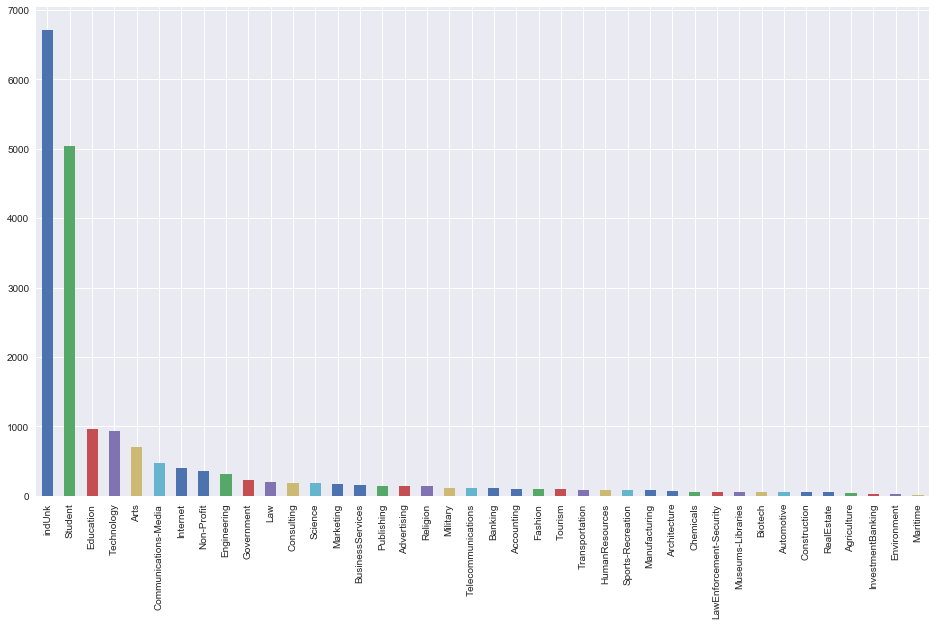

In [9]:
print(pd.crosstab(author_data.topic.fillna('missing'), columns="count",dropna=False))#.plot(kind="bar")
plt.figure(figsize=(16,9))
author_data['topic'].value_counts().plot(kind="bar")

col_0        count
sign              
Aquarius      1443
Aries         1572
Cancer        1702
Capricorn     1405
Gemini        1564
Leo           1589
Libra         1665
Pisces        1562
Sagittarius   1516
Scorpio       1599
Taurus        1611
Virgo         1753


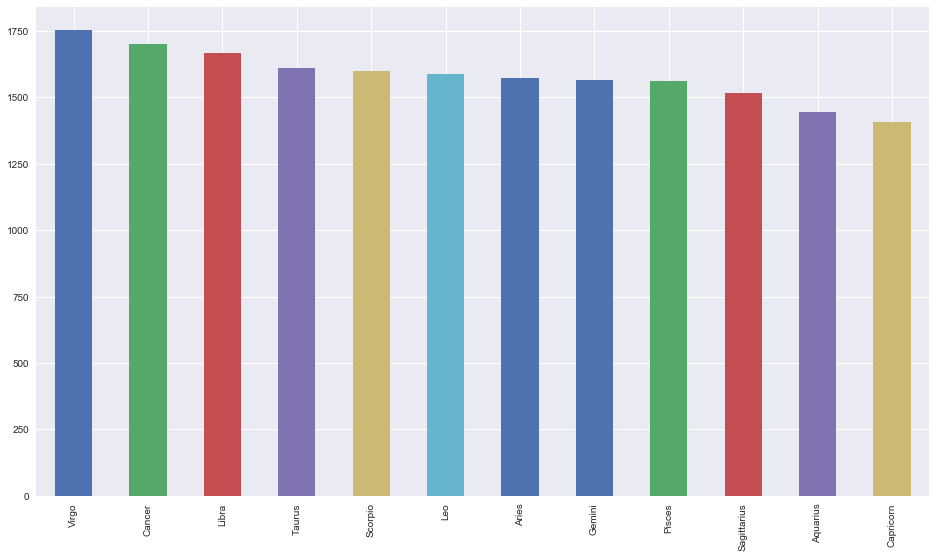

In [10]:
print(pd.crosstab(author_data.sign.fillna('missing'), columns="count",dropna=False))#.plot(kind="bar")
plt.figure(figsize=(16,9))
author_data['sign'].value_counts().plot(kind="bar")

# Clusters por edad y tópico

C:\Users\Alexis\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0,0.5,'Density')

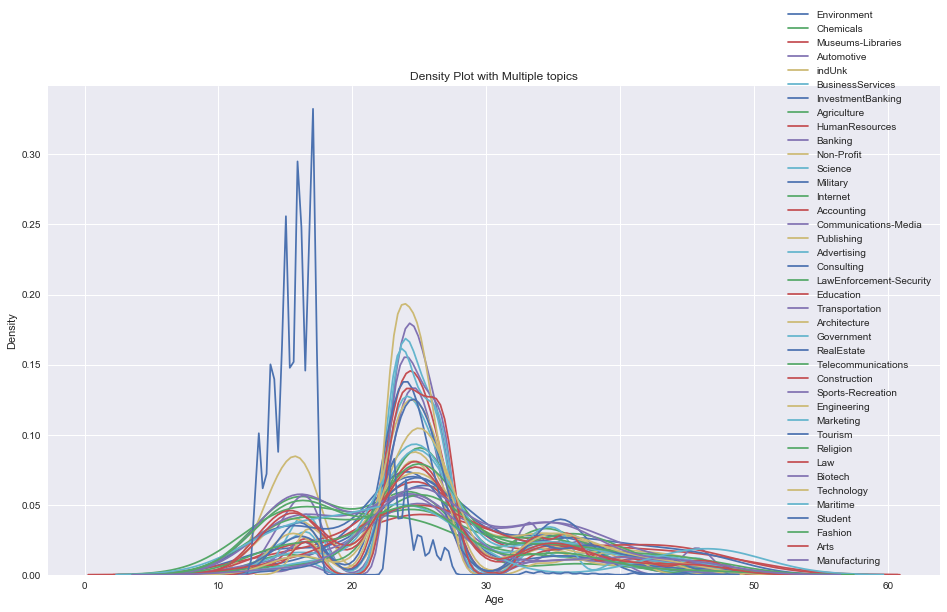

In [11]:
plt.figure(figsize=(16,9))

topics = list(set(author_data.topic))
for tpc in topics:
    subset = author_data[author_data['topic'] == tpc]
    
    sns.distplot(subset['age'], hist = False, kde = True,
#                  kde_kws = {'linewidth': 3},
                 label = tpc)
    
# Plot formatting
# plt.legend(prop={'size': 16}, title = 'Topic')
plt.title('Density Plot with Multiple topics')
plt.xlabel('Age')
plt.ylabel('Density')

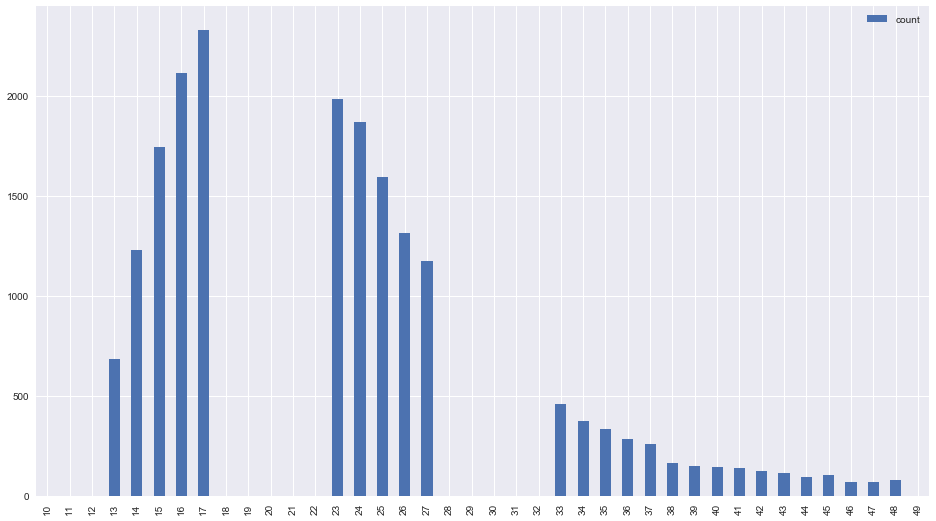

In [12]:
edades=pd.DataFrame(index=range(10,50))
edades=pd.concat([edades,pd.crosstab(author_data.age.fillna('missing'), columns="count")], axis=1)
edades.plot(kind="bar",figsize=(16,9))


In [13]:
def grup_ed(edad):
    if edad<20:
        return "A"
    if (edad>=20 and edad<30):
        return "B"
    if edad>=30:
        return "C"

In [14]:
author_data["grupo_edad"]=np.array([grup_ed(age) for age in author_data.age])
author_data.head()

,gender,age,topic,sign,grupo_edad
id,,,,,
2059027,male,15,Student,Leo,A
3581210,male,33,InvestmentBanking,Aquarius,C
3539003,female,14,indUnk,Aries,A
4172416,female,25,indUnk,Capricorn,B
3668238,female,17,Student,Gemini,A


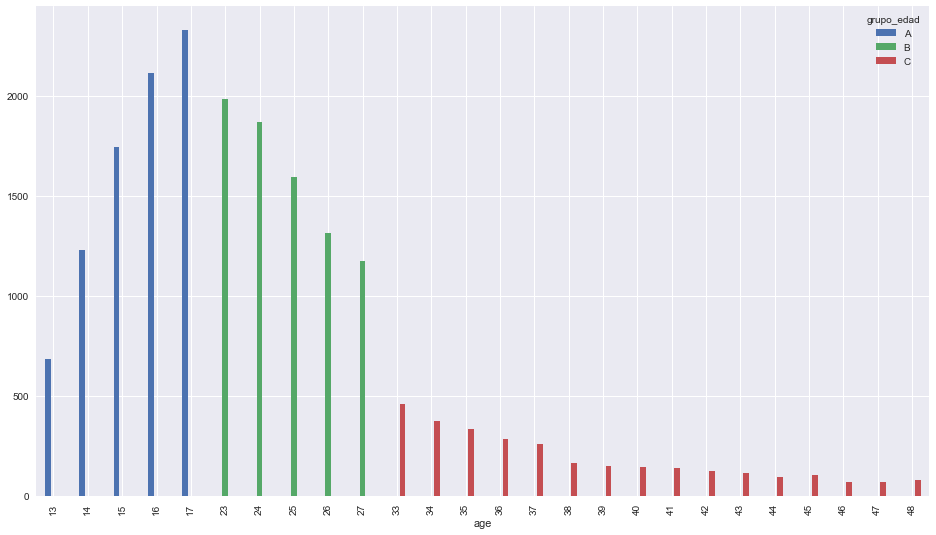

In [15]:
pd.crosstab(author_data.age.fillna('missing'), columns=author_data.grupo_edad,dropna=False).plot(kind="bar",figsize=(16,9))

In [16]:
gredad_topic=pd.crosstab(author_data.topic.fillna('missing'), 
                         columns=author_data.grupo_edad,dropna=False)#.plot(kind="bar")
gredad_topic

grupo_edad,A,B,C
topic,,,
Accounting,10,73,20
Advertising,5,105,31
Agriculture,16,13,7
Architecture,9,45,14
Arts,193,355,161
Automotive,12,30,11
Banking,3,83,21
Biotech,18,27,9
BusinessServices,24,100,37


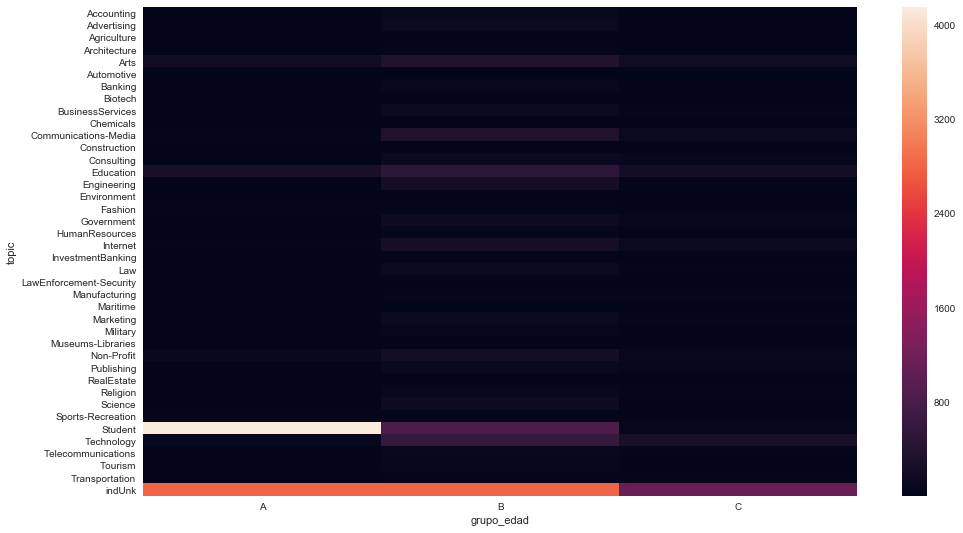

In [17]:
plt.figure(figsize=(16,9))
ax = sns.heatmap(gredad_topic)#, linewidths=.5)

* one hot encoding para los topicos
* normalizar edad (¿percentil o minimax?)
* ¿Spectral embedding a 3d?
* Clustering
 * Dendrograma Ward
 * DBScan

In [24]:
author_data.to_csv("author_data.csv")